<a href="https://colab.research.google.com/github/swethav1618/Handwritten-Digit-Recognition/blob/main/Handwritten_Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load the Dataset

MNIST stands for Modified National Institute of Standards and Technology.

It’s a classic dataset in machine learning and computer vision consisting of 70,000 handwritten digit images (0–9):

60,000 training images

10,000 test images

Each image is grayscale, size 28×28 pixels, and labeled with the corresponding digit.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Transform: convert to tensor + normalize to [0,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # mean=0.5, std=0.5
])

# Load train & test datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data',       # folder where the data will be stored
    train=True,          # True → loads the 60,000 training images
    download=True,       # downloads dataset if not already present
    transform=transform  # preprocessing (ToTensor + Normalize)
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 36.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.32MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.70MB/s]


Here’s how one can visualize some samples from the DataLoader:

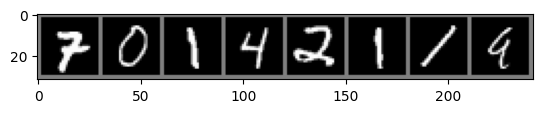

Labels: 7 0 1 4 2 1 1 9


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Function to unnormalize and show image
def imshow(img):
    img = img / 2 + 0.5   # unnormalize (because you normalized with mean=0.5, std=0.5)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Show first 8 images in the batch
imshow(torchvision.utils.make_grid(images[:8], nrow=8))
print("Labels:", ' '.join(str(labels[j].item()) for j in range(8)))


2. Build a CNN Model

A Convolutional Neural Network (CNN) learns image features automatically.

Layers:

Conv2d → ReLU → MaxPool (feature extraction)

Fully Connected (FC) layers (classification)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)   # input=1, output=32 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # output=64 filters
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)          # flattened feature map
        self.fc2 = nn.Linear(128, 10)                  # 10 classes (0-9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # conv1 -> relu -> pool
        x = self.pool(F.relu(self.conv2(x)))   # conv2 -> relu -> pool
        x = x.view(-1, 64 * 5 * 5)             # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


3. Define Loss Function & Optimizer

Loss: CrossEntropyLoss (standard for classification).

Optimizer: Adam or SGD.

In [ ]:
import torch.optim as optim

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


4. Train the Model

Loop through epochs:

Forward pass

Compute loss

Backward pass

Update weights

In [ ]:
for epoch in range(5):  # 5 epochs
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch 1, Loss: 0.16199082209776317
Epoch 2, Loss: 0.04673320141276901
Epoch 3, Loss: 0.03139953716648872
Epoch 4, Loss: 0.023266792876088915
Epoch 5, Loss: 0.01707157430340544


Evaluate the Model

Compute accuracy on test set.

Generate confusion matrix to see misclassifications.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.99
Confusion Matrix:
 [[ 977    0    0    0    0    0    0    3    0    0]
 [   0 1127    0    3    0    0    1    3    1    0]
 [   0    1 1026    0    0    0    0    4    1    0]
 [   0    0    2 1007    0    0    0    1    0    0]
 [   0    1    1    0  958    0    5    0    0   17]
 [   1    0    0   14    0  875    1    0    1    0]
 [   2    2    1    0    1    1  949    0    2    0]
 [   0    0    3    0    0    0    0 1023    1    1]
 [   3    1    3    2    0    0    1    2  958    4]
 [   0    0    0    1    1    3    0    3    1 1000]]
